In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import colormaps
import scipy
import scipy.stats as stats
import matplotlib.ticker as ticker
import json
import anndata as ad
from scipy.sparse import hstack
from moscot.problems.time import TemporalProblem
import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel
import petsc4py

In [4]:
adata = sc.read_h5ad("/vol/ExtraVol/Ontogeny_Clustered.h5ad")

In [5]:
adata.obs["stage_grouped"]

0        uninfected_adult
1        uninfected_adult
3        uninfected_adult
4        uninfected_adult
6        uninfected_adult
               ...       
62869    uninfected_adult
62870    uninfected_adult
62871    uninfected_adult
62872    uninfected_adult
62873    uninfected_adult
Name: stage_grouped, Length: 23004, dtype: category
Categories (4, object): ['after_weaning', 'embryonic', 'shortly_after_birth', 'uninfected_adult']

In [6]:
# Define the mapping from 'stage_grouped' categories to numeric values
stage_mapping = {
    'embryonic': 1.0,
    'shortly_after_birth': 2.0,
    'after_weaning': 3.0,
    'uninfected_adult': 4.0
}

# Map the 'stage_grouped' values to the numeric values using the defined mapping
adata.obs['stage_numerical'] = adata.obs['stage_grouped'].map(stage_mapping).astype(float)
adata.obs['stage_numerical']

0        4.0
1        4.0
3        4.0
4        4.0
6        4.0
        ... 
62869    4.0
62870    4.0
62871    4.0
62872    4.0
62873    4.0
Name: stage_numerical, Length: 23004, dtype: float64

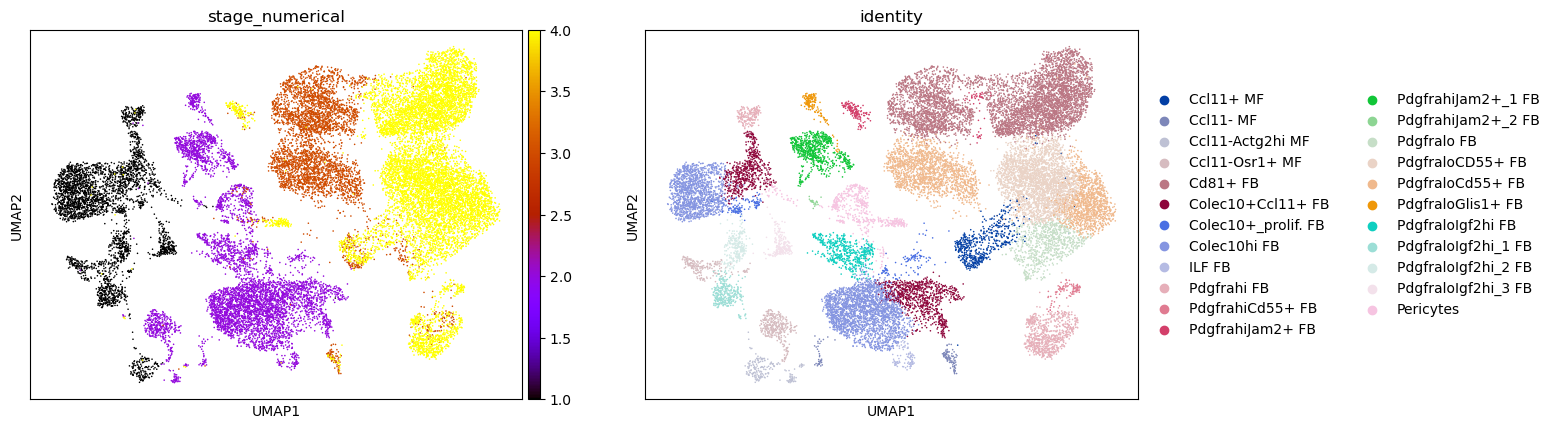

In [7]:
sc.pl.embedding(
    adata,
    basis="umap",
    color=["stage_numerical", "identity"],
    color_map="gnuplot",
)

In [8]:
tp = TemporalProblem(adata)

In [9]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="mouse", gene_set_apoptosis="mouse"
)

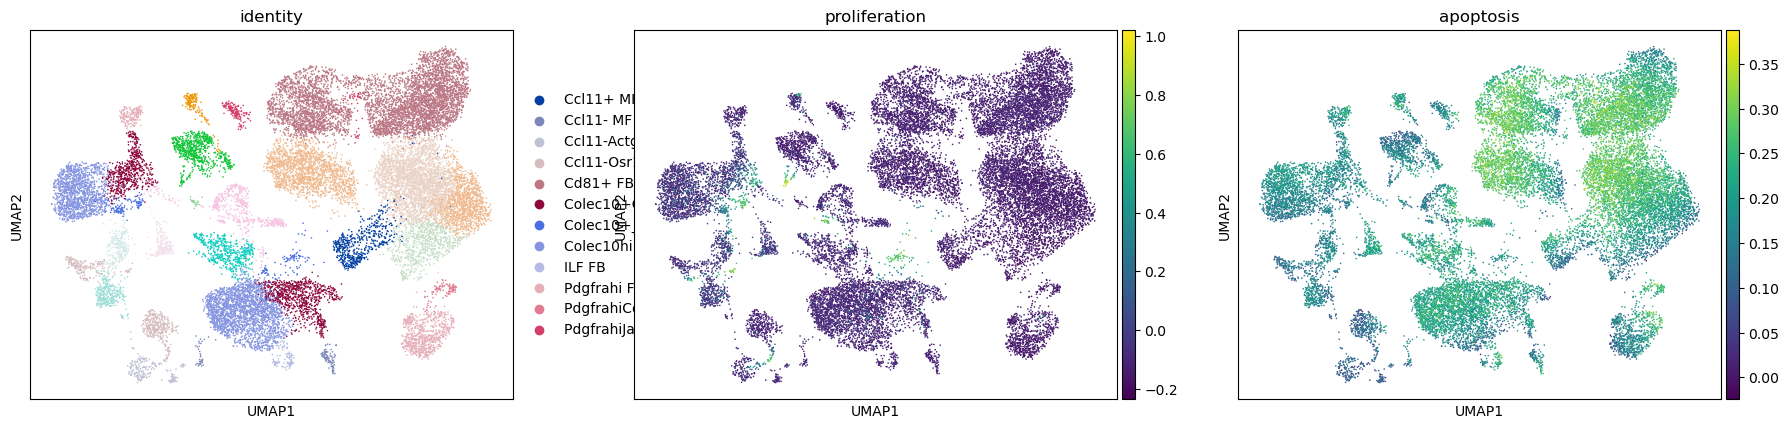

In [10]:
sc.pl.embedding(
    adata, basis="umap", color=["identity", "proliferation", "apoptosis"]
)

In [11]:
adata.obs['stage_numerical_categorical'] = pd.Categorical(adata.obs['stage_numerical'])
tp = tp.prepare(time_key="stage_numerical_categorical")

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  


In [12]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `3` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5648, 4110)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3470, 5648)].                                  
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(4110, 9776)].                                  


In [13]:
tmk = RealTimeKernel.from_moscot(tp)

In [14]:
tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33288.13time pair/s]


RealTimeKernel[n=23004, threshold='auto', self_transitions='all']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.13sim/s]


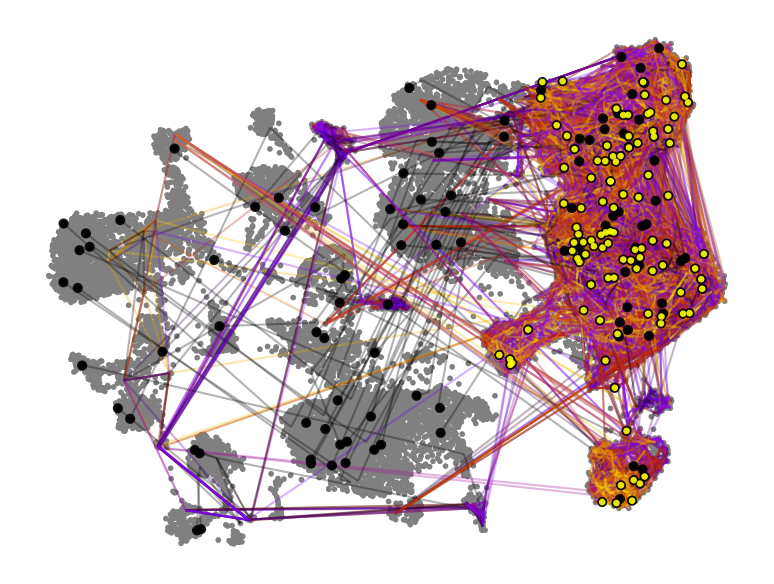

In [15]:
tmk.plot_random_walks(
    max_iter=500,
    #start_ixs={"stage_numerical": 0.0},
    basis="umap",
    seed=0,
    dpi=150,
    size=30,
)

In [45]:
adata.obs["leiden_anno"]

0        6/PdgfraloCd55+ FB
1                1/Cd81+ FB
3                1/Cd81+ FB
4        0/PdgfraloCD55+ FB
6                7/Cd81+ FB
                ...        
62869    0/PdgfraloCD55+ FB
62870    6/PdgfraloCd55+ FB
62871    6/PdgfraloCd55+ FB
62872    0/PdgfraloCD55+ FB
62873    0/PdgfraloCD55+ FB
Name: leiden_anno, Length: 23004, dtype: category
Categories (33, object): ['0/PdgfraloCD55+ FB', '1/Cd81+ FB', '2/Colec10hi FB', '3/Cd81+ FB', ..., '29/PdgfraloCd55+ FB', '30/PdgfrahiJam2+_2 FB', 'Ccl11-Osr1+ MF', 'Pericytes']

In [16]:
g = cr.estimators.GPCCA(tmk)
print(g)

GPCCA[kernel=RealTimeKernel[n=23004], initial_states=None, terminal_states=None]


/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


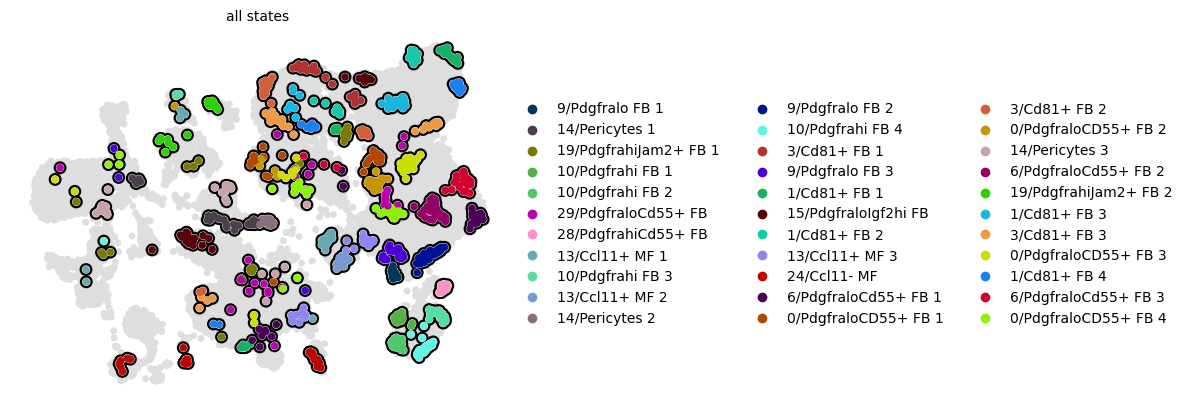

In [46]:
g.fit(cluster_key="leiden_anno", n_states=33, method='krylov')
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/ubuntu/anaconda3/envs/cellrankenv/lib/python3.11/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


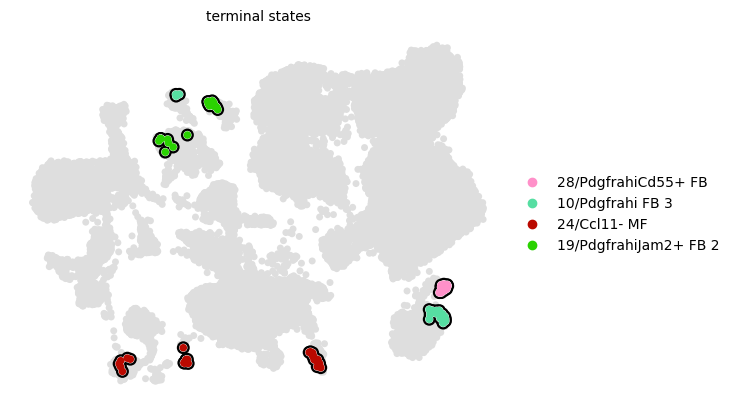

In [47]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

In [48]:
g.predict_initial_states()
g.plot_macrostates(which="initial", legend_loc="right", s=100)

ValueError: Found `30` overlapping cells between initial and terminal states. If this is intended, please use `allow_overlap=True`.